# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

El objetivo es determinar la rentabilidad de Surf o Ultimate y cómo varían los ingresos según la región y otras características de los usuarios. 

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_calls= pd.read_csv('/datasets/megaline_calls.csv')

df_internet= pd.read_csv('/datasets/megaline_internet.csv')

df_messages=pd.read_csv('/datasets/megaline_messages.csv')

df_plans= pd.read_csv('/datasets/megaline_plans.csv')

df_users=pd.read_csv('/datasets/megaline_users.csv')



## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

In [3]:
# Corregir el tipo de dato de las columnas tipo fechas.
df_calls['call_date']   = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date']  = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_users['reg_date']    = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date']  = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

## Tarifas

In [4]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
print(df_plans.info)
print()
# Verificar valores ausentes
print("Valores ausentes en cada columna:")
print(df_plans.isna().sum())

# Verificar valores duplicados
print("\nNúmero de filas duplicadas:", df_plans.duplicated().sum())

# Ver cuántos valores únicos hay en la columna 'plan_name'
print(f"Cantidad de valores únicos en 'plan_name': {df_plans['plan_name'].nunique()}, Valores únicos: {df_plans['plan_name'].unique()}")

#Mostrar filas duplicadas (si hay)
if df_plans.duplicated().sum() > 0:
    print("\nFilas duplicadas:")
    print(df[df.duplicated()])


<bound method DataFrame.info of    messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  >

Valores ausentes en cada columna:
messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
plan_name                0
dtype: int64

Número de filas duplicadas: 0
Cantidad de valores únicos en 'plan_name': 2, Valores únicos: ['surf' 'ultimate']


In [5]:
# Imprime una muestra de los datos para las tarifas
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


De manera estructural no se encuentra ningún problema como valores nulos o duplicados en el DataFrame, confirmamos que tiene 2 valores únicos que son los planes surf y ultimate. En cuanto a los datos hay diferencias entre las dos tarifas ,Ultimate tiene más mensajes, más datos y más minutos incluidos, pero también cuesta más al mes. En cambio Surf tiene costos adicionales más altos en todos los aspectos (por GB, mensaje y minuto).



## Corregir datos

In [6]:
# Redondeo de minutos hacia arriba
df_plans['minutes_included'] = np.ceil(df_plans['minutes_included']).astype(int)

# Redondeo de megabytes a gigabytes (1000 MB = 1 GB)
df_plans['mb_per_month_included'] = np.ceil(df_plans['mb_per_month_included'] / 1024).astype(int)


## Enriquecer los datos

In [7]:

df_plans = df_plans.rename(columns={'mb_per_month_included':'gb_per_month'})
df_plans


,messages_included,gb_per_month,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Usuarios/as

In [8]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

df_users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [9]:
print("Valores ausentes en cada columna:")
print(df_users.isna().sum())

# Verificar valores duplicados
print("\nNúmero de filas duplicadas:", df_users.duplicated().sum())

#Mostrar filas duplicadas (si hay)
if df_users.duplicated().sum() > 0:
    print("\nFilas duplicadas:")
    print(df[df.duplicated()])
# Imprime una muestra de datos para usuarios
df_users.head()

Valores ausentes en cada columna:
user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

Número de filas duplicadas: 0


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


Se observa que no hay valores duplicados y que solo hay valores asusentes en la columna churn_date con 466, pero si recordamos las indicaciones en la instroducción del proyecto churn_date es la fecha en la que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando fue extraída esta base de datos).Para que no se queden los valores de esta manera, podemos cambiar los valores NaN por activo, y los que no sean Nan por inactivo.  


### Corregir los datos

In [10]:
# Filtrar los clientes que tienen una fecha de cancelación (es decir, que se dieron de baja)
clientes_dados_de_baja = df_users[df_users['churn_date'].notna()]

# Mostrar los primeros registros de los clientes que se dieron de baja
print(clientes_dados_de_baja.head())

# Para resaltar visualmente estos registros
def resaltar_filas(row):
    if pd.notna(row['churn_date']):
        return ['background-color: yellow'] * len(row)  # Resalta la fila con un color
    else:
        return [''] * len(row)  # Sin cambio para los clientes activos

# Aplicar el estilo a todo el DataFrame
df_users.style.apply(resaltar_filas, axis=1)




    user_id first_name last_name  age  \
6      1006     Jesusa  Bradford   73   
12     1012    Jonelle   Mcbride   59   
22     1022         Bo      Snow   73   
40     1040      Paris    Santos   72   
50     1050       Jone      Owen   23   

                                               city   reg_date      plan  \
6            San Francisco-Oakland-Berkeley, CA MSA 2018-11-27  ultimate   
12           Chicago-Naperville-Elgin, IL-IN-WI MSA 2018-06-28      surf   
22        New York-Newark-Jersey City, NY-NJ-PA MSA 2018-04-20      surf   
40  Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA 2018-12-23      surf   
50    Miami-Fort Lauderdale-West Palm Beach, FL MSA 2018-03-20  ultimate   

   churn_date  
6  2018-12-18  
12 2018-11-16  
22 2018-09-07  
40 2018-12-30  
50 2018-10-07  


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24 00:00:00,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13 00:00:00,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21 00:00:00,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28 00:00:00,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23 00:00:00,surf,NaT
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29 00:00:00,surf,NaT
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27 00:00:00,ultimate,2018-12-18 00:00:00
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11 00:00:00,surf,NaT
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03 00:00:00,ultimate,NaT
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22 00:00:00,surf,NaT


### Enriquecer los datos

In [11]:
# Crear una nueva columna 'active_status' que indique si el cliente está activo o no
df_users['active_status'] = df_users['churn_date'].isna().map({True: 'Active', False: 'Inactive'})

# Resumen del número de clientes activos e inactivos
print(df_users['active_status'].value_counts())

df_users['active_status'].head()

Active      466
Inactive     34
Name: active_status, dtype: int64


0    Active
1    Active
2    Active
3    Active
4    Active
Name: active_status, dtype: object

## Llamadas

In [12]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()

# Verificar valores ausentes
print("Valores ausentes en cada columna:")
print(df_calls.isna().sum())

# Verificar valores duplicados
print("\nNúmero de filas duplicadas:", df_calls.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB
Valores ausentes en cada columna:
id           0
user_id      0
call_date    0
duration     0
dtype: int64

Número de filas duplicadas: 0


In [13]:
# Imprime una muestra de datos para las llamadas

df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


 A primera vista no se observan valores ausentes ni duplicados, de manera estructural se encuentran correctos, pero recordemos que Megaline redondea los segundos a minutos en llamadas y que  cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto. La columna duration en la tabla calls se en minutos.

### Corregir los datos

In [14]:
#Redondear  los minutos hacia arriba
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)
#Comprobar cambios
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


### Enriquecer los datos

Como se debe añadir la cuota mensual en función del plan de llamadas, podemos agregar la columna mes a las llamadas.

In [15]:
# Incluir columna mes
df_calls['month'] = df_calls['call_date'].dt.month
df_calls.head(3)

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12


## Mensajes

In [16]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()

# Verificar valores ausentes
print("Valores ausentes en cada columna:")
print(df_messages.isna().sum())

# Verificar valores duplicados
print("\nNúmero de filas duplicadas:", df_messages.duplicated().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB
Valores ausentes en cada columna:
id              0
user_id         0
message_date    0
dtype: int64

Número de filas duplicadas: 0


In [17]:
# Imprime una muestra de datos para los mensajes
df_messages.head()


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Esta tabla muestra las fechas y los ids únicos en que los usuarios mandaron mensajes. No tiene valores ausentes y los tipos de datos son los adecuados.

### Corregir los datos

No se encuentran probloemas mayores en este Data Frame.

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [18]:
#agregar columna del mes
df_messages['month'] = df_messages['message_date'].dt.month
df_messages.head(3)

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12


## Internet

In [19]:
# Imprime la información general/resumida sobre el DataFrame de internet

df_internet.info()

# Verificar valores ausentes
print("Valores ausentes en cada columna:")
print(df_internet.isna().sum())

# Verificar valores duplicados
print("\nNúmero de filas duplicadas:", df_internet.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB
Valores ausentes en cada columna:
id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

Número de filas duplicadas: 0


In [20]:
# Imprime una muestra de datos para el tráfico de internet

df_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


La tabla muestra el consumo por sesión, no tiene valores ausentes y los tipos de datos son adecuados. La tabla muestra el consumo en megas recordemos que el el cobro se hace en gigas, se db que hacer la conversión y corregir la tabla.

### Corregir los datos

In [21]:
#cambiar unidades
df_internet['mb_used'] = df_internet['mb_used']/1024
df_internet = df_internet.rename(columns={'mb_used':'gb_used'})
df_internet.head(3)

,id,user_id,session_date,gb_used
0,1000_13,1000,2018-12-29,0.087754
1,1000_204,1000,2018-12-31,0.000000
2,1000_379,1000,2018-12-28,0.644922


### Enriquecer los datos

Agregue la columna del mes para que se pueda identificar de mejor forma.

In [22]:
#agregar columna mes
df_internet['month'] = df_internet['session_date'].dt.month
df_internet.head(3)

,id,user_id,session_date,gb_used,month
0,1000_13,1000,2018-12-29,0.087754,12
1,1000_204,1000,2018-12-31,0.000000,12
2,1000_379,1000,2018-12-28,0.644922,12


## Estudiar las condiciones de las tarifas

In [23]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras

df_plans

,messages_included,gb_per_month,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


In [24]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.

df_ncalls = df_calls.groupby(['user_id','month'])['id'].count().reset_index()
df_ncalls = df_ncalls.rename(columns={'id':'num_calls'})
df_ncalls.head()

,user_id,month,num_calls
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64


In [25]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
df_minutes = df_calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
df_minutes = df_minutes.rename(columns={'duration': 'total_minutes'})
df_minutes.head()


,user_id,month,total_minutes
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426


In [26]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
df_messages['month'] = df_messages['message_date'].dt.month

df_nmessages = df_messages.groupby(['user_id', 'month'])['id'].count().reset_index()
df_nmessages = df_nmessages.rename(columns={'id': 'num_messages'})
df_nmessages.head()



,user_id,month,num_messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


In [27]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
df_internet['month'] = df_internet['session_date'].dt.month

df_traffic = df_internet.groupby(['user_id', 'month'])['gb_used'].sum().reset_index()
df_traffic = df_traffic.rename(columns={'mb_used': 'total_traffic'})
df_traffic['gb_used'] = df_traffic['gb_used'].round(0)
df_traffic.head()


,user_id,month,gb_used
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,13.0
3,1001,10,22.0
4,1001,11,18.0


Junte los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.

In [28]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
# Combinar datos de llamadas y minutos
df_user_data = pd.merge(df_ncalls, df_minutes, on=['user_id', 'month'], how='outer')

# Agregar datos de mensajes
df_user_data = pd.merge(df_user_data, df_nmessages, on=['user_id', 'month'], how='outer')

# Agregar datos de tráfico de Internet
df_user_data = pd.merge(df_user_data, df_traffic, on=['user_id', 'month'], how='outer')

# Redondear gb_used a cero decimales
df_user_data['gb_used'] = round(df_user_data['gb_used'])

df_user_data.head()



,user_id,month,num_calls,total_minutes,num_messages,gb_used
0,1000,12,16.0,124.0,11.0,2.0
1,1001,8,27.0,182.0,30.0,7.0
2,1001,9,49.0,315.0,44.0,13.0
3,1001,10,65.0,393.0,53.0,22.0
4,1001,11,64.0,426.0,36.0,18.0


In [29]:
#  Hay valores ausentes en la tabla por los usuarios que no usaron cierto servicio durante algun mes. Como no usaron el servicio, se establece el valor en 0.
df_user_data= df_user_data.fillna(0)
df_user_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        2293 non-null   int64  
 1   month          2293 non-null   int64  
 2   num_calls      2293 non-null   float64
 3   total_minutes  2293 non-null   float64
 4   num_messages   2293 non-null   float64
 5   gb_used        2293 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 125.4 KB


In [30]:
# Añade la información de la tarifa

#ubicación del usuario
df_user_data = df_user_data.set_index('user_id').join(df_users.set_index('user_id'))
df_user_data = df_user_data.reset_index()
df_user_data.head()


,user_id,month,num_calls,total_minutes,num_messages,gb_used,first_name,last_name,age,city,reg_date,plan,churn_date,active_status
0,1000,12,16.0,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,Active
1,1001,8,27.0,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,Active
2,1001,9,49.0,315.0,44.0,13.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,Active
3,1001,10,65.0,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,Active
4,1001,11,64.0,426.0,36.0,18.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,Active


Calculo los ingresos mensuales por usuario

In [31]:
# Calcula el ingreso mensual para cada usuario

def monthly_income(row):
    if row['plan'] == 'ultimate':
        income = 70  # Tarifa base para Ultimate
        income += max(0, (row['total_minutes'] - 3000)) * 0.01  # Exceso de minutos
        income += max(0, (row['num_messages'] - 1000)) * 0.01  # Exceso de SMS
        income += max(0, (row['gb_used'] - 30)) * 7  # Exceso de GB
    else:  # Plan 'surf'
        income = 20  # Tarifa base para Surf
        income += max(0, (row['total_minutes'] - 500)) * 0.03  # Exceso de minutos
        income += max(0, (row['num_messages'] - 50)) * 0.03  # Exceso de SMS
        income += max(0, (row['gb_used'] - 15)) * 10  # Exceso de GB
    
    return income


# Aplicar la función para calcular ingresos
df_user_data['income'] = df_user_data.apply(monthly_income, axis=1)

# O visualizar directamente si usas un Jupyter Notebook
df_user_data[['user_id', 'plan', 'total_minutes', 'num_messages', 'gb_used', 'income']]


,user_id,plan,total_minutes,num_messages,gb_used,income
0,1000,ultimate,124.0,11.0,2.0,70.00
1,1001,surf,182.0,30.0,7.0,20.00
2,1001,surf,315.0,44.0,13.0,20.00
3,1001,surf,393.0,53.0,22.0,90.09
4,1001,surf,426.0,36.0,18.0,50.00
...,...,...,...,...,...,...
2288,1498,surf,339.0,0.0,23.0,100.00
2289,1499,surf,346.0,0.0,13.0,20.00
2290,1499,surf,385.0,0.0,19.0,60.00
2291,1499,surf,308.0,0.0,16.0,30.00


## Estudia el comportamiento de usuario

### Llamadas

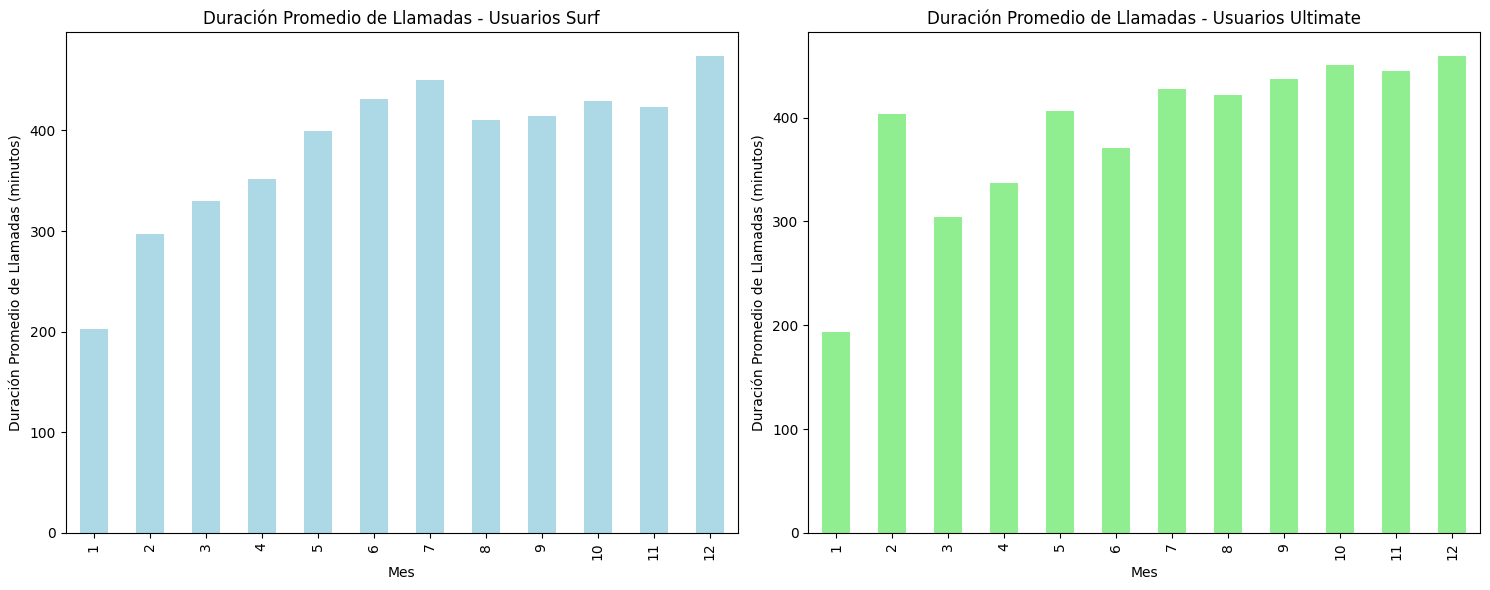

plan         surf   ultimate
count   12.000000   12.00000
mean   131.083333   60.00000
std    107.939763   49.16022
min      2.000000    4.00000
25%     43.250000   18.75000
50%    109.000000   53.00000
75%    204.750000   91.00000
max    318.000000  151.00000


In [32]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.


# Separar clientes por plan
df_user_data_u = df_user_data.query('plan == "ultimate" ')  # Clientes Ultimate
df_user_data_s = df_user_data.query('plan == "surf" ')  # Clientes Surf

# Configuración del gráfico
plt.subplots(figsize=(15, 6))

# Gráfico de barras para usuarios de Surf
df_user_data_s.groupby('month')['total_minutes'].mean().plot(kind='bar', color='lightblue', ax=plt.subplot(1, 2, 1))
plt.title('Duración Promedio de Llamadas - Usuarios Surf')
plt.xlabel('Mes')
plt.ylabel('Duración Promedio de Llamadas (minutos)')

# Gráfico de barras para usuarios de Ultimate
df_user_data_u.groupby('month')['total_minutes'].mean().plot(kind='bar', color='lightgreen', ax=plt.subplot(1, 2, 2))
plt.title('Duración Promedio de Llamadas - Usuarios Ultimate')
plt.xlabel('Mes')
plt.ylabel('Duración Promedio de Llamadas (minutos)')

plt.tight_layout()
plt.show()

# Agrupar por mes y plan, y contar los usuarios por mes para cada plan
users_per_month_by_plan = df_user_data.groupby(['month', 'plan'])['user_id'].count().unstack()

# Calcular estadísticas descriptivas del número de usuarios por mes para cada plan
users_per_month_stats = users_per_month_by_plan.describe()

# Mostrar las estadísticas
print(users_per_month_stats)





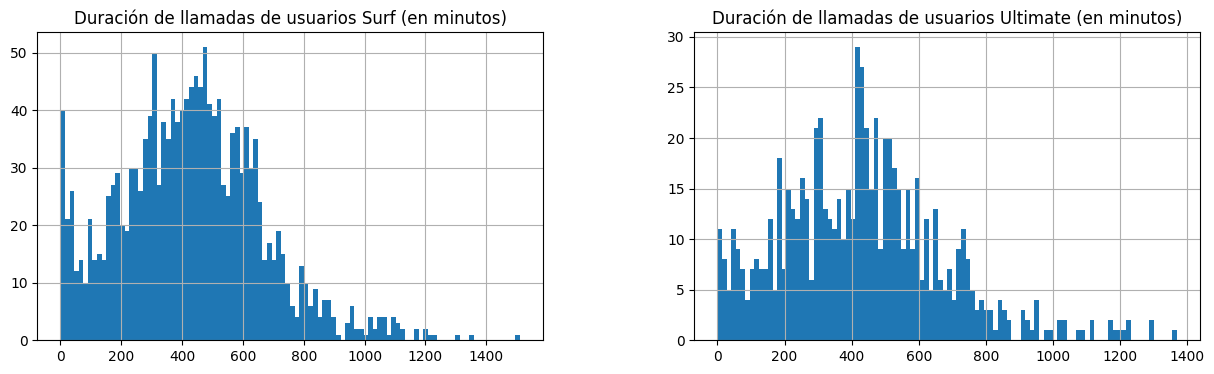

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,428.749523,234.453150,0.0,272.0,425.0,576.00,1510.0
ultimate,720.0,430.450000,240.508762,0.0,260.0,424.0,565.25,1369.0


In [33]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

# Filtrar usuarios por plan (surf y ultimate)
df_user_data_u = df_user_data[df_user_data['plan'] == 'ultimate']
df_user_data_s = df_user_data[df_user_data['plan'] == 'surf']

# Graficar los histogramas para la columna 'total_minutes'
plt.subplots(figsize=(15, 4))

df_user_data_s.hist(column='total_minutes', ax=plt.subplot(1, 2, 1), bins=100)
plt.title('Duración de llamadas de usuarios Surf (en minutos)')

df_user_data_u.hist(column='total_minutes', ax=plt.subplot(1, 2, 2), bins=100)
plt.title('Duración de llamadas de usuarios Ultimate (en minutos)')

plt.show()


#Estadísticas
df_user_data.groupby('plan')['total_minutes'].describe()

In [34]:
# Calcula la media y la varianza de la duración mensual de llamadas.

# Calcular la media y la varianza de la duración mensual de llamadas
df_user_data_grouped = df_user_data.groupby(['plan', 'month'])['total_minutes'].agg(['mean', 'var'])

# Mostrar los resultados
print(df_user_data_grouped)


                      mean           var
plan     month                          
surf     1      203.000000  15842.000000
         2      297.000000  52226.500000
         3      330.000000  35809.363636
         4      351.540000  50866.743265
         5      399.584416  59754.219754
         6      431.298969  45592.628436
         7      449.983471  61005.099725
         8      410.111111  54344.645963
         9      414.226804  46595.958656
         10     429.729958  52278.664056
         11     423.325088  51607.021602
         12     473.836478  63629.518918
ultimate 1      193.500000  16572.333333
         2      403.142857  76889.476190
         3      304.250000  61984.931818
         4      336.857143  34888.928571
         5      406.241379  43841.046798
         6      370.957447  42503.563367
         7      427.067797  72563.374635
         8      421.436620  53645.506640
         9      437.511628  57070.464569
         10     450.735849  54261.910512
         11     

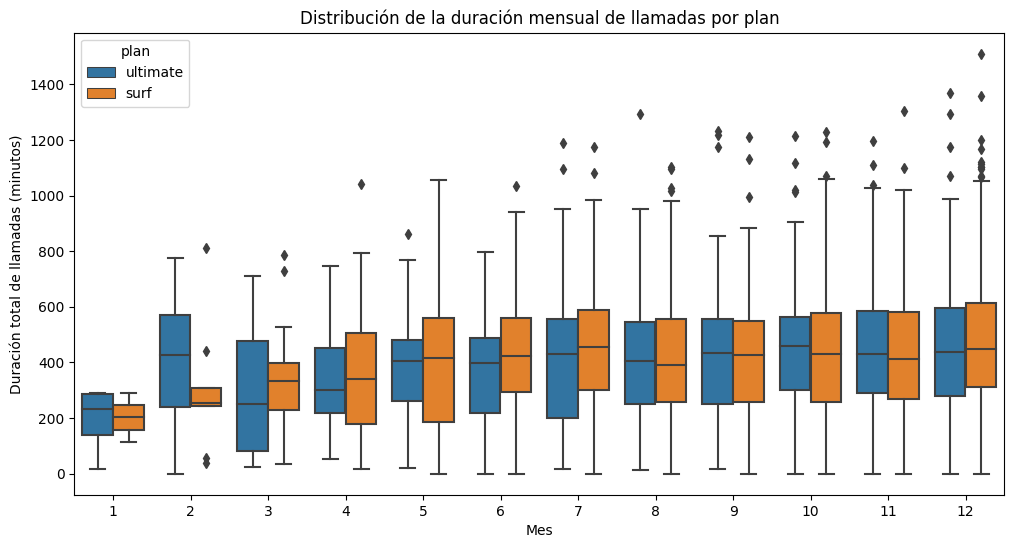

In [35]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas


plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='total_minutes', hue='plan', data=df_user_data)
plt.title('Distribución de la duración mensual de llamadas por plan')
plt.xlabel('Mes')
plt.ylabel('Duración total de llamadas (minutos)')
plt.show()


Los usuarios de los planes Surf y Ultimate muestran patrones similares en la duración promedio de llamadas mensuales, con promedios cercanos (429 y 430 minutos, respectivamente). Sin embargo, los usuarios de Surf tienen una mayor dispersión en sus duraciones, reflejando un uso más heterogéneo. El plan Surf cuenta con más usuarios en promedio por mes, lo que podría influir en estrategias de marketing. Los usuarios de Ultimate muestran un comportamiento más estable, lo que facilita predicciones de ingresos.
El diagrama de caja muestra que los usuarios de los planes Surf y Ultimate tienen distribuciones similares en la duración mensual de llamadas, pero con diferencias clave. Los usuarios de Surf presentan una mayor variabilidad, con valores atípicos más pronunciados, lo que indica que algunos usuarios realizan un uso significativamente superior. En contraste, los usuarios de Ultimate tienen una distribución más uniforme y concentrada, reflejando un comportamiento más consistente. Esto sugiere que el plan Ultimate atrae a usuarios con patrones de llamadas más predecibles, mientras que Surf podría ser más adecuado para perfiles variados o extremos.

### Mensajes

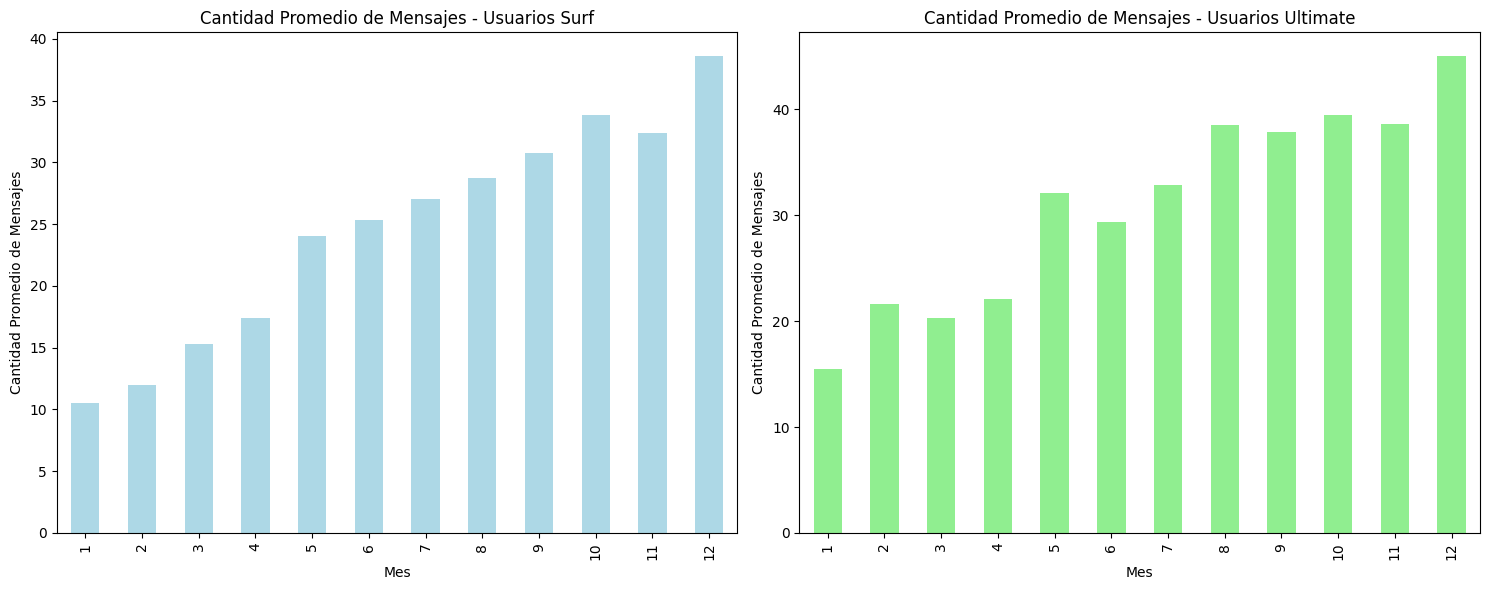

plan         surf   ultimate
count   12.000000   12.00000
mean   131.083333   60.00000
std    107.939763   49.16022
min      2.000000    4.00000
25%     43.250000   18.75000
50%    109.000000   53.00000
75%    204.750000   91.00000
max    318.000000  151.00000


In [36]:
# Gráfico de barras para mensajes
plt.subplots(figsize=(15, 6))

# Gráfico de barras para usuarios de Surf
df_user_data_s.groupby('month')['num_messages'].mean().plot(
    kind='bar', color='lightblue', ax=plt.subplot(1, 2, 1))
plt.title('Cantidad Promedio de Mensajes - Usuarios Surf')
plt.xlabel('Mes')
plt.ylabel('Cantidad Promedio de Mensajes')

# Gráfico de barras para usuarios de Ultimate
df_user_data_u.groupby('month')['num_messages'].mean().plot(
    kind='bar', color='lightgreen', ax=plt.subplot(1, 2, 2))
plt.title('Cantidad Promedio de Mensajes - Usuarios Ultimate')
plt.xlabel('Mes')
plt.ylabel('Cantidad Promedio de Mensajes')

plt.tight_layout()
plt.show()

# Agrupar por mes y plan, y contar los usuarios por mes para cada plan
users_per_month_by_plan = df_user_data.groupby(['month', 'plan'])['user_id'].count().unstack()

# Calcular estadísticas descriptivas del número de usuarios por mes para cada plan
users_per_month_stats = users_per_month_by_plan.describe()

# Mostrar las estadísticas descriptivas
print(users_per_month_stats)



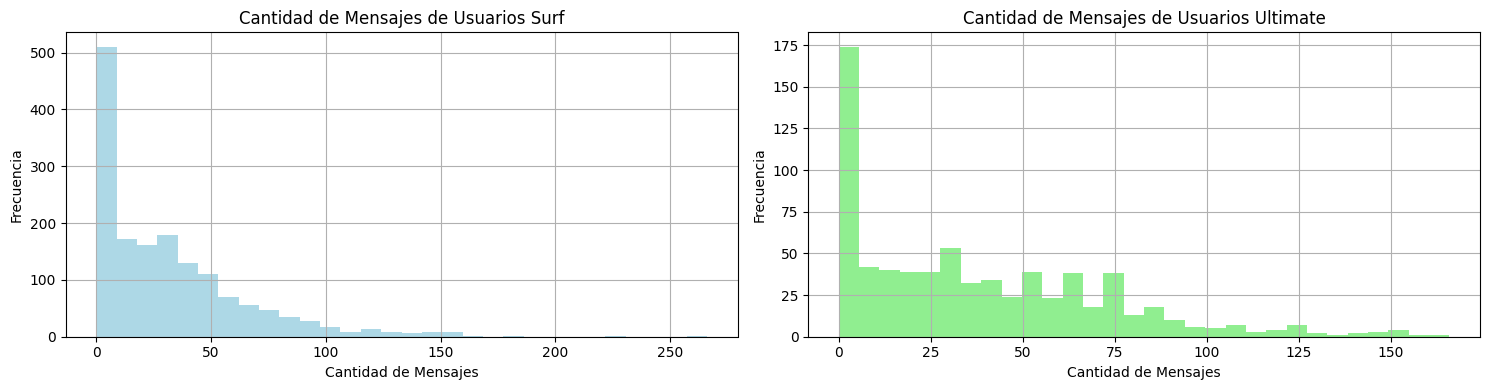

           count       mean        std  min  25%   50%   75%    max
plan                                                               
surf      1573.0  31.159568  33.566717  0.0  3.0  24.0  47.0  266.0
ultimate   720.0  37.551389  34.767179  0.0  7.0  30.0  61.0  166.0


In [37]:
# Filtrar usuarios por plan (surf y ultimate)
df_user_data_u = df_user_data[df_user_data['plan'] == 'ultimate']
df_user_data_s = df_user_data[df_user_data['plan'] == 'surf']

# Graficar los histogramas para la columna 'num_messages' (cantidad de mensajes)
plt.subplots(figsize=(15, 4))

# Histograma para usuarios de Surf
df_user_data_s.hist(column='num_messages', ax=plt.subplot(1, 2, 1), bins=30, color='lightblue')
plt.title('Cantidad de Mensajes de Usuarios Surf')
plt.xlabel('Cantidad de Mensajes')
plt.ylabel('Frecuencia')

# Histograma para usuarios de Ultimate
df_user_data_u.hist(column='num_messages', ax=plt.subplot(1, 2, 2), bins=30, color='lightgreen')
plt.title('Cantidad de Mensajes de Usuarios Ultimate')
plt.xlabel('Cantidad de Mensajes')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Calcular estadísticas descriptivas del número de mensajes por plan
messages_usage_stats = df_user_data.groupby('plan')['num_messages'].describe()
print(messages_usage_stats)




In [38]:

# Calcular la media y la varianza del número de mensajes por plan y mes
df_user_data_grouped_messages = df_user_data.groupby(['plan', 'month'])['num_messages'].agg(['mean', 'var'])

# Mostrar los resultados
print(df_user_data_grouped_messages)




                     mean          var
plan     month                        
surf     1      10.500000   220.500000
         2      12.000000   386.000000
         3      15.260870   346.565217
         4      17.400000   501.591837
         5      24.012987   847.197198
         6      25.298969   914.920103
         7      27.033058   923.915565
         8      28.777778  1029.515528
         9      30.762887  1003.829496
         10     33.839662  1275.465708
         11     32.385159  1065.344034
         12     38.600629  1458.158612
ultimate 1      15.500000   313.666667
         2      21.571429   478.285714
         3      20.250000   654.386364
         4      22.047619   544.147619
         5      32.103448  1297.310345
         6      29.340426   857.620722
         7      32.830508   960.488019
         8      38.478873  1196.367404
         9      37.895349  1050.918331
         10     39.443396  1221.106289
         11     38.606299  1232.669166
         12     45.006623

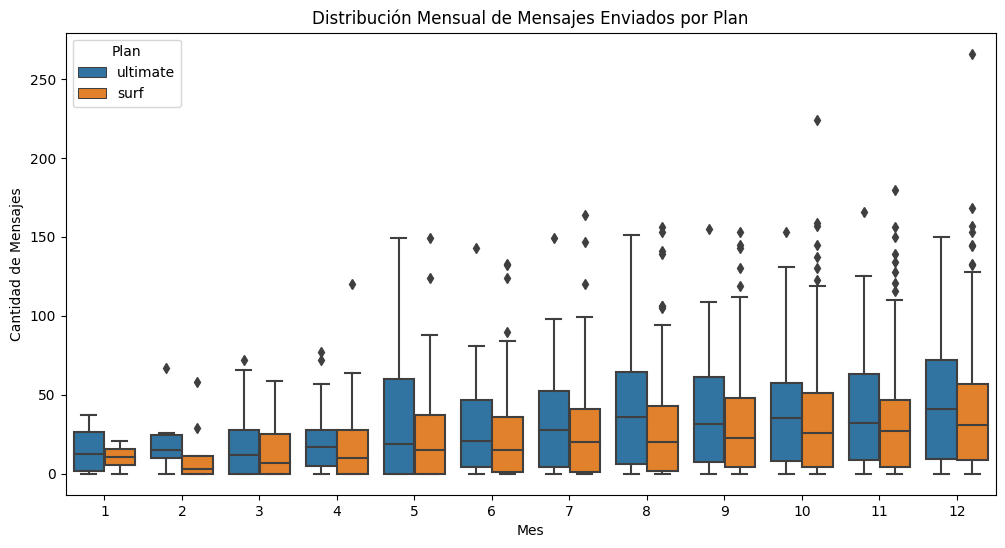

In [39]:

# Traza un diagrama de caja para visualizar la distribución de la duración mensual de mensajes
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='num_messages', hue='plan', data=df_user_data)
plt.title('Distribución Mensual de Mensajes Enviados por Plan')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Mensajes')
plt.legend(title='Plan')
plt.show()


Los usuarios del plan Ultimate envían, en promedio, más mensajes mensuales (37.55) que los del plan Surf (31.16), lo que refleja un uso más intensivo de esta función entre los usuarios de Ultimate.

La cantidad promedio de mensajes aumenta progresivamente durante el año para ambos planes, alcanzando picos en los últimos meses, especialmente en diciembre.

Los usuarios de Surf muestran una mayor variabilidad en el número de mensajes enviados, lo que se evidencia en valores atípicos más pronunciados en los diagramas de caja.

Diferencias en la dispersión: Aunque ambos planes presentan tendencias similares, los usuarios de Ultimate tienen una dispersión menor en los mensajes enviados, lo que sugiere un comportamiento más consistente.

Preferencias del usuario: El plan Ultimate parece ser preferido por usuarios que envían más mensajes de manera constante, mientras que Surf es más popular entre aquellos con patrones de uso más variados.

### Internet

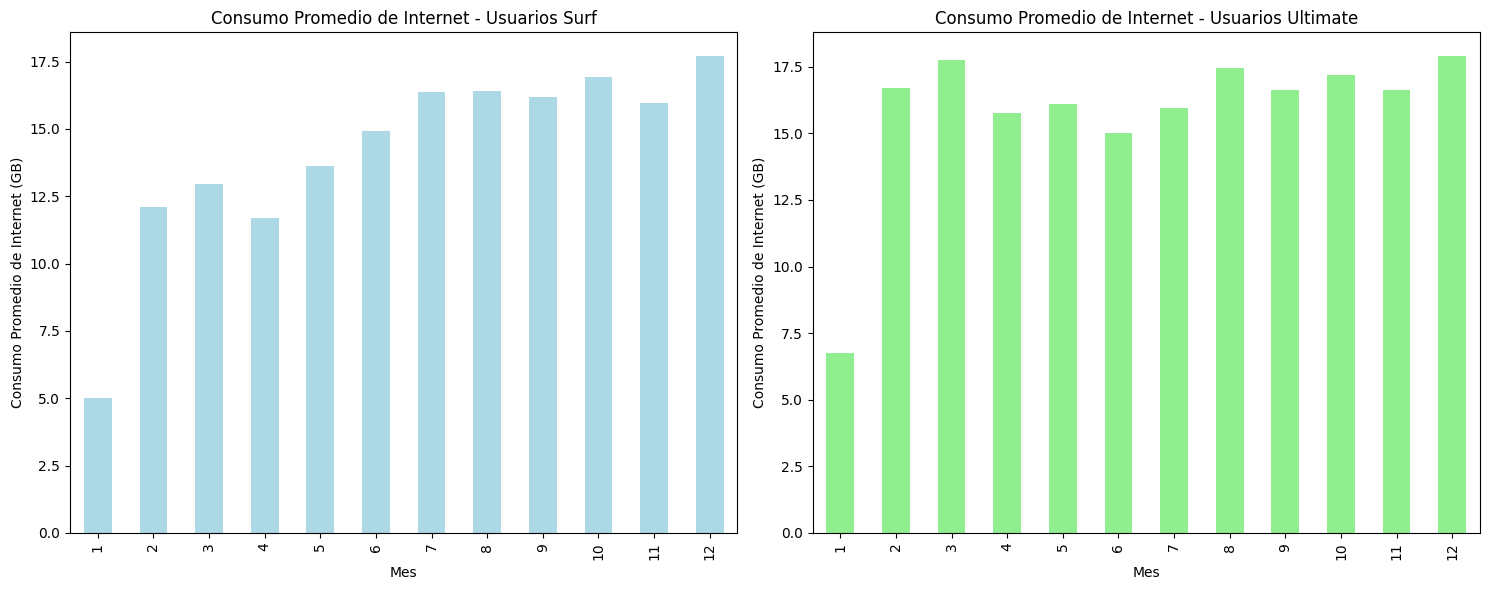

Estadísticas descriptivas del consumo de Internet por plan:
           count       mean       std  min   25%   50%   75%   max
plan                                                              
surf      1573.0  16.164654  7.821659  0.0  12.0  16.0  21.0  69.0
ultimate   720.0  16.806944  7.672918  0.0  12.0  16.0  21.0  46.0


In [40]:
# Filtrar usuarios por plan (surf y ultimate)
df_user_data_u = df_user_data[df_user_data['plan'] == 'ultimate']
df_user_data_s = df_user_data[df_user_data['plan'] == 'surf']

# Gráfico de barras para el consumo de Internet
plt.subplots(figsize=(15, 6))

# Gráfico de barras para usuarios de Surf
df_user_data_s.groupby('month')['gb_used'].mean().plot(kind='bar', color='lightblue', ax=plt.subplot(1, 2, 1))
plt.title('Consumo Promedio de Internet - Usuarios Surf')
plt.xlabel('Mes')
plt.ylabel('Consumo Promedio de Internet (GB)')

# Gráfico de barras para usuarios de Ultimate
df_user_data_u.groupby('month')['gb_used'].mean().plot(kind='bar', color='lightgreen', ax=plt.subplot(1, 2, 2))
plt.title('Consumo Promedio de Internet - Usuarios Ultimate')
plt.xlabel('Mes')
plt.ylabel('Consumo Promedio de Internet (GB)')

plt.tight_layout()
plt.show()


# Estadísticas descriptivas del consumo de Internet por plan
internet_usage_stats = df_user_data.groupby('plan')['gb_used'].describe()

# Mostrar las estadísticas descriptivas
print("Estadísticas descriptivas del consumo de Internet por plan:")
print(internet_usage_stats)

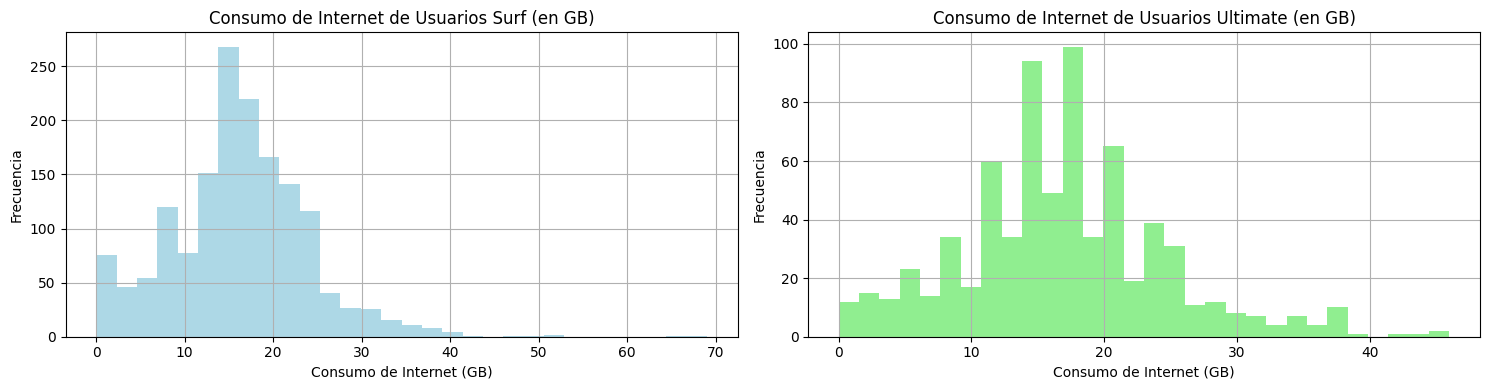

           count       mean       std  min   25%   50%   75%   max
plan                                                              
surf      1573.0  16.164654  7.821659  0.0  12.0  16.0  21.0  69.0
ultimate   720.0  16.806944  7.672918  0.0  12.0  16.0  21.0  46.0


In [41]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

# Filtrar usuarios por plan (surf y ultimate)
df_user_data_u = df_user_data[df_user_data['plan'] == 'ultimate']
df_user_data_s = df_user_data[df_user_data['plan'] == 'surf']

# Graficar los histogramas para la columna 'gb_used' (tráfico de Internet)
plt.subplots(figsize=(15, 4))

# Histograma para usuarios de Surf
df_user_data_s.hist(column='gb_used', ax=plt.subplot(1, 2, 1), bins=30, color='lightblue')
plt.title('Consumo de Internet de Usuarios Surf (en GB)')
plt.xlabel('Consumo de Internet (GB)')
plt.ylabel('Frecuencia')

# Histograma para usuarios de Ultimate
df_user_data_u.hist(column='gb_used', ax=plt.subplot(1, 2, 2), bins=30, color='lightgreen')
plt.title('Consumo de Internet de Usuarios Ultimate (en GB)')
plt.xlabel('Consumo de Internet (GB)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Calcular estadísticas descriptivas del tráfico de Internet por plan
internet_usage_stats = df_user_data.groupby('plan')['gb_used'].describe()
print(internet_usage_stats)


In [42]:
# Calcular la media y la varianza del tráfico de Internet (GB) por plan y mes
df_user_data_grouped_internet = df_user_data.groupby(['plan', 'month'])['gb_used'].agg(['mean', 'var'])

# Mostrar los resultados
print(df_user_data_grouped_internet)


                     mean         var
plan     month                       
surf     1       5.000000   18.000000
         2      12.111111   39.611111
         3      12.956522   66.407115
         4      11.680000   56.181224
         5      13.610390   59.846206
         6      14.907216   46.897552
         7      16.380165   62.454270
         8      16.401235   71.521241
         9      16.190722   48.994525
         10     16.911392   59.131946
         11     15.954064   54.696464
         12     17.701258   67.894699
ultimate 1       6.750000   16.250000
         2      16.714286   35.904762
         3      17.750000  129.477273
         4      15.761905   81.790476
         5      16.103448   54.167488
         6      15.000000   69.173913
         7      15.932203   65.478083
         8      17.436620   57.020926
         9      16.639535   47.127360
         10     17.169811   54.789937
         11     16.614173   55.349956
         12     17.894040   59.375364


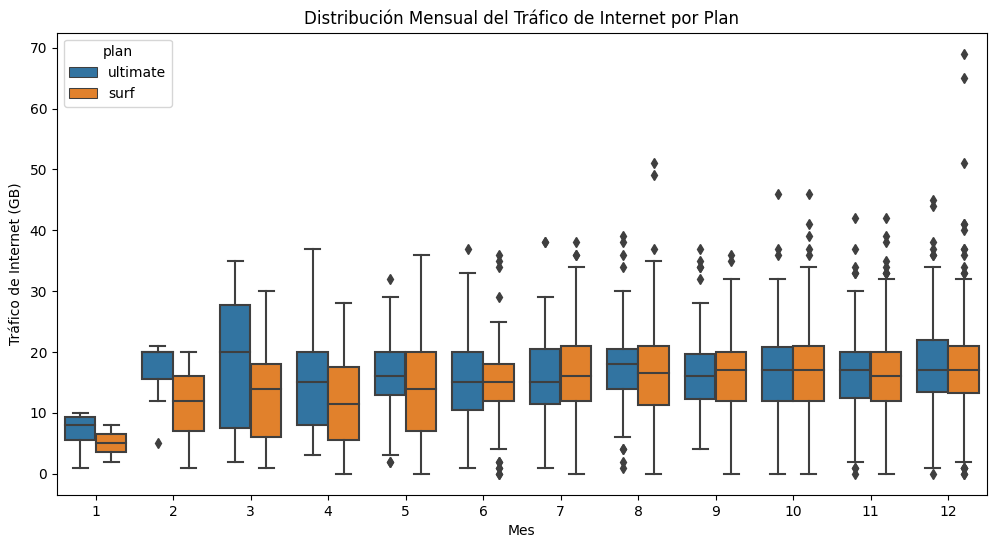

In [43]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Crear el diagrama de bigotes (boxplot)
sns.boxplot(x='month', y='gb_used', hue='plan', data=df_user_data)

# Títulos y etiquetas
plt.title('Distribución Mensual del Tráfico de Internet por Plan')
plt.xlabel('Mes')
plt.ylabel('Tráfico de Internet (GB)')

# Mostrar el gráfico
plt.show()

Los usuarios de los planes Surf y Ultimate tienen consumos promedio de internet muy parecidos (16.16 GB y 16.81 GB respectivamente). Esto indica que el tipo de plan no afecta significativamente el consumo promedio de internet.
Ambos planes muestran un aumento gradual en el consumo promedio de internet hacia finales del año, alcanzando su punto más alto en diciembre.Los usuarios del plan Surf presentan mayor variabilidad en su consumo mensual, con valores máximos significativamente más altos (69 GB frente a 46 GB en Ultimate).
Los diagramas de caja revelan que, aunque la mediana y los percentiles 25 y 75 son similares para ambos planes, hay más valores atípicos (usuarios con consumos extremos) en el plan Surf.
La variabilidad del consumo es más alta en los primeros meses del año para ambos planes, estabilizándose en el segundo semestre.

Estos resultados reflejan que el consumo de internet no está tan influenciado por el tipo de plan como otros servicios, pero ciertos usuarios del plan Surf tienden a usar significativamente más datos.

## Ingreso

Estadísticas - Surf:
count    12.000000
mean     48.958847
std      13.607938
min      20.000000
25%      42.553193
50%      50.629562
75%      59.954201
max      66.468994
Name: income, dtype: float64
Estadísticas - Ultimate:
count    12.000000
mean     71.723139
std       1.075211
min      70.000000
25%      71.237711
50%      71.844501
75%      72.663146
max      73.059603
Name: income, dtype: float64


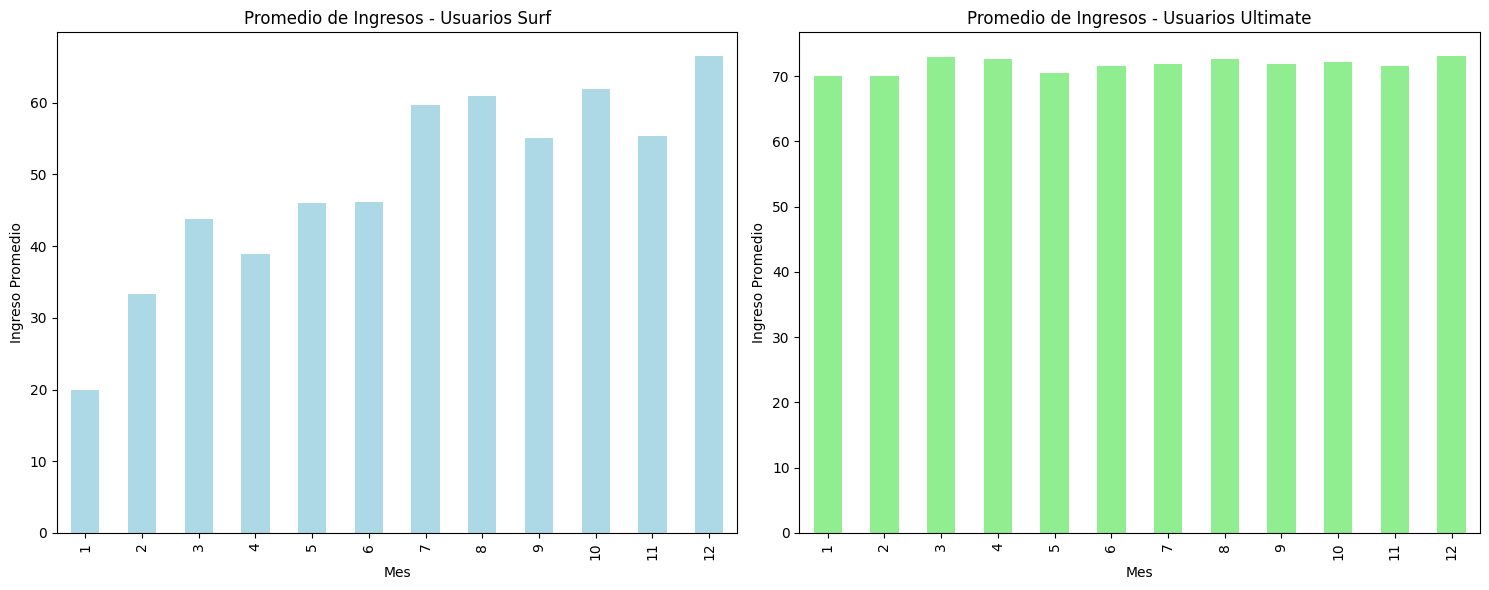

In [44]:
# Promedio de ingresos por cada plan por cada mes
plt.subplots(figsize=(15, 6))

# Gráfico para usuarios de Surf
df_user_data_s_monthly_income = df_user_data_s.groupby('month')['income'].mean()
df_user_data_s_monthly_income.plot(kind='bar', color='lightblue', ax=plt.subplot(1, 2, 1))
plt.title('Promedio de Ingresos - Usuarios Surf')
plt.xlabel('Mes')
plt.ylabel('Ingreso Promedio')

# Estadísticas: Media y Varianza para Surf
print("Estadísticas - Surf:")
print(df_user_data_s_monthly_income.describe())

# Gráfico para usuarios de Ultimate
df_user_data_u_monthly_income = df_user_data_u.groupby('month')['income'].mean()
df_user_data_u_monthly_income.plot(kind='bar', color='lightgreen', ax=plt.subplot(1, 2, 2))
plt.title('Promedio de Ingresos - Usuarios Ultimate')
plt.xlabel('Mes')
plt.ylabel('Ingreso Promedio')

print("Estadísticas - Ultimate:")
print(df_user_data_u_monthly_income.describe())

# Mostrar el gráfico
plt.tight_layout()
plt.show()





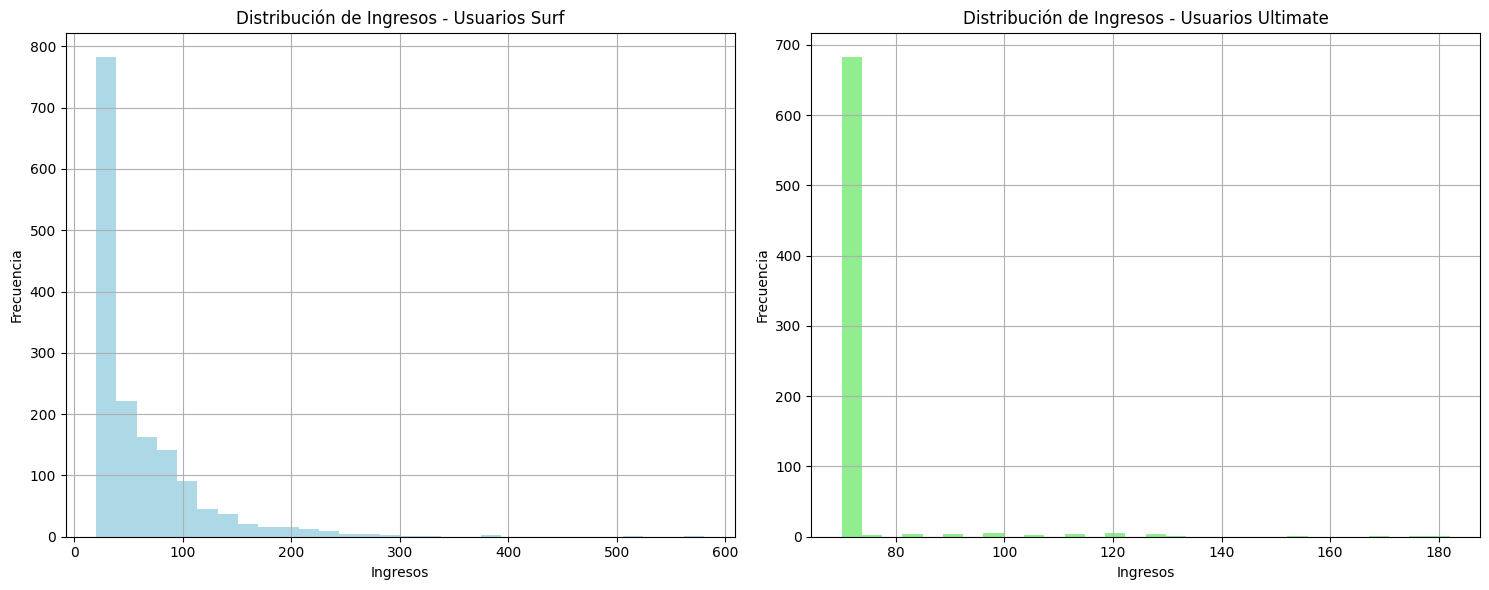

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,57.559555,53.839188,20.0,20.0,40.0,80.0,580.37
ultimate,720.0,72.109722,10.812881,70.0,70.0,70.0,70.0,182.00


In [45]:
# Filtrar usuarios por plan (surf y ultimate)
df_user_data_u = df_user_data[df_user_data['plan'] == 'ultimate']
df_user_data_s = df_user_data[df_user_data['plan'] == 'surf']

# Configurar el gráfico de histogramas
plt.subplots(figsize=(15, 6))

# Histograma para usuarios de Surf
df_user_data_s['income'].hist(ax=plt.subplot(1, 2, 1), bins=30, color='lightblue')
plt.title('Distribución de Ingresos - Usuarios Surf')
plt.xlabel('Ingresos')
plt.ylabel('Frecuencia')

# Histograma para usuarios de Ultimate
df_user_data_u['income'].hist(ax=plt.subplot(1, 2, 2), bins=30, color='lightgreen')
plt.title('Distribución de Ingresos - Usuarios Ultimate')
plt.xlabel('Ingresos')
plt.ylabel('Frecuencia')

# Ajustar el diseño
plt.tight_layout()
plt.show()

df_user_data.groupby('plan')['income'].describe()

In [46]:
# Calcular la media y la varianza de ingresos por plan y mes
income_stats = df_user_data.groupby(['plan', 'month'])['income'].agg(['mean', 'var'])

# Mostrar las estadísticas
print(income_stats)

                     mean          var
plan     month                        
surf     1      20.000000     0.000000
         2      33.285556   350.378878
         3      43.767391  1432.306911
         4      38.910600  1094.519789
         5      46.069740  1843.126247
         6      46.183505  1826.650902
         7      59.616198  2841.246674
         8      60.968210  3468.970079
         9      55.075619  2103.556950
         10     61.876920  2992.959733
         11     55.283428  2337.760001
         12     66.468994  4400.498089
ultimate 1      70.000000     0.000000
         2      70.000000     0.000000
         3      72.916667   102.083333
         4      72.666667   115.033333
         5      70.482759     6.758621
         6      71.489362    59.516189
         7      71.898305   104.472238
         8      72.661972   130.712676
         9      71.790698    60.167442
         10     72.113208   156.958491
         11     71.598425    85.702537
         12     73.059603

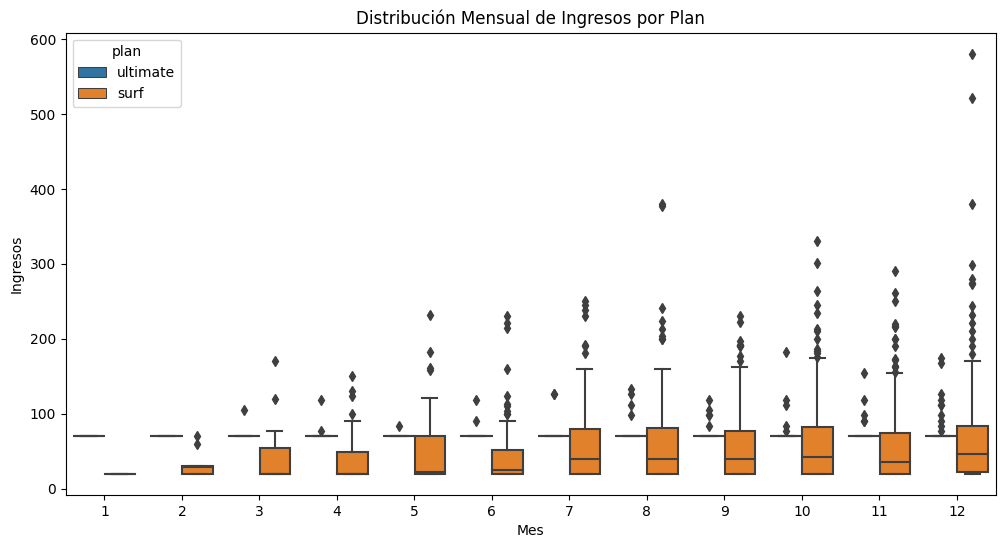

In [47]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Crear el diagrama de bigotes
sns.boxplot(x='month', y='income', hue='plan', data=df_user_data)

# Títulos y etiquetas
plt.title('Distribución Mensual de Ingresos por Plan')
plt.xlabel('Mes')
plt.ylabel('Ingresos')

# Mostrar el gráfico
plt.show()


El análisis muestra que el plan Ultimate genera ingresos más estables y altos, con un promedio mensual cercano a $72 y el plan Surf tiene ingresos más variables, con un promedio de $57.56. Los usuarios de Ultimate presentan menor dispersión en sus ingresos, indicando un consumo más uniforme. Por otro lado, el plan Surf muestra una mayor variabilidad, con ingresos que tienden a aumentar hacia fin de año. En términos de tráfico de internet, ambos planes tienen consumos similares en promedio, pero los usuarios de Surf exhiben mayor diversidad en su comportamiento. En resumen, Ultimate asegura ingresos consistentes, mientras que Surf ofrece potencial para captar usuarios diversos con mayores fluctuaciones.

## Prueba las hipótesis estadísticas

*Hipótesis sobre igualdad de medias en los distintos planes

**Hipotesis nula:** el ingreso promedio mensual del plan surf es igual al del ultimate

**Hipotesis alterna:** el ingreso promedio mensual del plan surf es diferente al del ultimate

**Prueba estadística:** Hipótesis sobre la igualdad de las medias de dos poblaciones

**Valor alfa:** 5%

In [1]:
# Prueba las hipótesis

alpha = 0.05 

#Prueba de hipótesis 1
h1 = st.ttest_ind(df_user_data_s['income'], df_user_data_u['income'],equal_var = False)
print('p-value: ', h1.pvalue)

if h1.pvalue < alpha:
    print("Se rechaza la hipótesis nula")
else:
    print("No se rechaza la hipótesis nula") 



NameError: name 'st' is not defined

Se rechaza la hipótesis nula. Esto indica que existe una diferencia estadísticamente significativa entre los ingresos promedio mensuales de los planes Surf y Ultimate.
Interpretación: El plan Ultimate genera ingresos consistentemente más altos en comparación con el plan Surf.

*Hipótesis sobre igualdad de medias en distintas regiones*

La segunda hipótesis a probar es que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

**Hipotesis nula:** el ingreso promedio de los usuarios del área NY-NJ es igua al de los usuarios de otras regiones.

**Hipotesis alterna:** el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones

**Prueba estadística:** Hipótesis sobre la igualdad de las medias de dos poblaciones

**Valor alfa:** 5%

In [ ]:
# Prueba las hipótesis

df_user_data.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')

#Prueba de hipótesis 2
h2 = st.ttest_ind(df_user_data.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')['income'], 
                  df_user_data.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')['income'],equal_var = False)

print('p-value: ', h2.pvalue)

if h2.pvalue < alpha:
    print("Se rechaza la hipótesis nula")
else:
    print("No se rechaza la hipótesis nula") 

p-value:  0.020366686562084176
Se rechaza la hipótesis nula


La diferencia en los ingresos promedio entre los dos grupos (usuarios de NY-NJ vs. usuarios de otras regiones) es estadísticamente significativa, lo que sugiere que el ingreso promedio de los usuarios en el área NY-NJ es diferente al de los usuarios de otras regiones.

## Conclusión general

**Ingreso promedio de los planes Surf y Ultimate:** Se determinó que el ingreso promedio mensual de los usuarios del plan Ultimate es significativamente mayor que el del plan Surf. La media mensual de los usuarios del plan Surf es 60.71 USD, mientras que la del plan Ultimate es 72.31 USD.

**Ingreso promedio por región:** También se encontró que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones, lo que sugiere que las diferencias geográficas y socioeconómicas juegan un papel en las decisiones de los usuarios al elegir un plan.

**Ingresos Totales y Comparación entre Planes:**
Los ingresos totales del año 2018 para los dos planes fueron:
Plan Surf: 95,491.18 USD, con 333 usuarios.
Plan Ultimate: 52,066.00 USD, con 157 usuarios.
Aunque el plan Surf generó más ingresos totales debido a la mayor cantidad de usuarios, el plan Ultimate muestra un ingreso promedio por usuario superior, lo que indica que los usuarios de este plan están dispuestos a pagar más por los servicios.

En resumen, el análisis ha mostrado que el plan Ultimate, a pesar de tener un número de usuarios menor, genera un ingreso promedio más alto por usuario. Esto sugiere que, para maximizar los ingresos, Megaline debería focalizar esfuerzos en atraer más usuarios a este plan.
Si bien el plan Surf genera mayores ingresos totales, la diferencia en el ingreso promedio por usuario implica que optimizar la estrategia de publicidad y precios para el plan Ultimate podría resultar en mayores ingresos anuales y un crecimiento más equilibrado entre ambos planes.